In [1]:
# Cell 1: Imports and Setup
import gc
gc.collect()
import numpy as np
import pandas as pd
import os
import h5py
import time
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# TPU/GPU initialization
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import R2Score as RSquare

# # TPU strategy setup
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     tpu_strategy = tf.distribute.TPUStrategy(tpu)
#     print(f"Running on TPU with {tpu_strategy.num_replicas_in_sync} cores")
# except (ValueError, RuntimeError):
tf.config.experimental.set_memory_growth(
    tf.config.list_physical_devices('GPU')[0], True
)

# Enable gradient checkpointing (trades compute for memory)
tf.config.experimental.enable_tensor_float_32_execution(False)
tpu_strategy = tf.distribute.get_strategy()
print("Running on CPU/GPU")

# %%
# Cell 2: Load Data Files
all_files = []
for dirname, _, filenames in os.walk('./data_set'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))
all_files.sort()
pprint(all_files)


2025-10-09 15:37:15.719227: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-09 15:37:15.732702: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-09 15:37:15.745713: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-09 15:37:15.749532: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-09 15:37:15.764080: I tensorflow/core/platform/cpu_feature_guar

Running on CPU/GPU
['./data_set/N-CMAPSS_DS01-005.h5',
 './data_set/N-CMAPSS_DS02-006.h5',
 './data_set/N-CMAPSS_DS03-012.h5',
 './data_set/N-CMAPSS_DS04.h5',
 './data_set/N-CMAPSS_DS05.h5',
 './data_set/N-CMAPSS_DS06.h5',
 './data_set/N-CMAPSS_DS07.h5',
 './data_set/N-CMAPSS_DS08a-009.h5',
 './data_set/N-CMAPSS_DS08c-008.h5',
 './data_set/N-CMAPSS_DS08d-010.h5',
 './data_set/N-CMAPSS_Example_data_loading_and_exploration.ipynb',
 './data_set/Run_to_Failure_Simulation_Under_Real_Flight_Conditions_Dataset.pdf',
 './data_set/data-06-00005-v2.pdf',
 './data_set/flight_profile_DS02.png',
 './data_set/kde_DS02.png']


I0000 00:00:1760024237.567443   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760024237.764381   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760024237.764546   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
def read_hdf(filename):
    t = time.process_time()  
    with h5py.File(filename, 'r') as hdf:
        # Development set
        W_dev = np.array(hdf.get('W_dev'), dtype=np.float32)
        X_s_dev = np.array(hdf.get('X_s_dev'), dtype=np.float32)
        X_v_dev = np.array(hdf.get('X_v_dev'), dtype=np.float32)
        T_dev = np.array(hdf.get('T_dev'), dtype=np.float32)
        Y_dev = np.array(hdf.get('Y_dev'), dtype=np.float32)
        A_dev = np.array(hdf.get('A_dev'), dtype=np.float32)

        # Test set
        W_test = np.array(hdf.get('W_test'), dtype=np.float32)
        X_s_test = np.array(hdf.get('X_s_test'), dtype=np.float32)
        X_v_test = np.array(hdf.get('X_v_test'), dtype=np.float32)
        T_test = np.array(hdf.get('T_test'), dtype=np.float32)
        Y_test = np.array(hdf.get('Y_test'), dtype=np.float32)
        A_test = np.array(hdf.get('A_test'), dtype=np.float32)
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))
        
        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
                        
    ## Train data
    df_a_dev=pd.DataFrame(A_dev,columns=A_var)
    df_t_dev=pd.DataFrame(T_dev,columns=T_var)
    df_w_dev=pd.DataFrame(W_dev,columns=W_var)
    df_xs_dev=pd.DataFrame(X_s_dev,columns=X_s_var)
    df_xv_dev=pd.DataFrame(X_v_dev,columns=X_v_var)
    df_y_dev=pd.DataFrame(Y_dev,columns=['RUL'])

    #get rul
    trainy=df_y_dev[['RUL']]

    #get x from sensors values
    trainx=pd.concat([df_xs_dev,df_w_dev],axis=1)

    print(type(trainy),trainy.shape, type(trainx), trainx.shape)

    ## Test data
    df_a_test=pd.DataFrame(A_test,columns=A_var)
    df_t_test=pd.DataFrame(T_test,columns=T_var)
    df_w_test=pd.DataFrame(W_test,columns=W_var)
    df_xs_test=pd.DataFrame(X_s_test,columns=X_s_var)
    df_xv_test=pd.DataFrame(X_v_test,columns=X_v_var)
    df_y_test=pd.DataFrame(Y_test,columns=['RUL'])

    #get health state from aux
    testy=df_y_test[['RUL']]

    #get x from sensors values
    testx=pd.concat([df_xs_test,df_w_test],axis=1)

    print(type(testy),testy.shape, type(testx), testx.shape)

    print('')
    print("Operation time (min): " , (time.process_time()-t)/60)
    print('')

    return (trainx,trainy,df_a_dev,testx,testy,df_a_test)

In [3]:

# %%
# Cell 4: Load Specific Dataset
curr_file = all_files[2]
print(curr_file)
trainx, trainy, adev, testx, testy, atest = read_hdf(filename=curr_file)
trainx.info(show_counts=True)


./data_set/N-CMAPSS_DS03-012.h5
<class 'pandas.core.frame.DataFrame'> (5571277, 1) <class 'pandas.core.frame.DataFrame'> (5571277, 18)
<class 'pandas.core.frame.DataFrame'> (4251560, 1) <class 'pandas.core.frame.DataFrame'> (4251560, 18)

Operation time (min):  0.05521568833333333

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571277 entries, 0 to 5571276
Data columns (total 18 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   T24     5571277 non-null  float32
 1   T30     5571277 non-null  float32
 2   T48     5571277 non-null  float32
 3   T50     5571277 non-null  float32
 4   P15     5571277 non-null  float32
 5   P2      5571277 non-null  float32
 6   P21     5571277 non-null  float32
 7   P24     5571277 non-null  float32
 8   Ps30    5571277 non-null  float32
 9   P40     5571277 non-null  float32
 10  P50     5571277 non-null  float32
 11  Nf      5571277 non-null  float32
 12  Nc      5571277 non-null  float32
 13  Wf      557127

In [4]:

# %%
# Cell 5: Apply RUL Clipping (IMPORTANT!)
MAX_RUL = 125  # Standard for turbofan datasets

print(f"Before clipping - Train RUL range: [{trainy['RUL'].min():.1f}, {trainy['RUL'].max():.1f}]")
print(f"Before clipping - Test RUL range: [{testy['RUL'].min():.1f}, {testy['RUL'].max():.1f}]")

trainy['RUL'] = trainy['RUL'].clip(upper=MAX_RUL)
testy['RUL'] = testy['RUL'].clip(upper=MAX_RUL)

print(f"\nAfter clipping - Train RUL range: [{trainy['RUL'].min():.1f}, {trainy['RUL'].max():.1f}]")
print(f"After clipping - Test RUL range: [{testy['RUL'].min():.1f}, {testy['RUL'].max():.1f}]")

# %%


Before clipping - Train RUL range: [0.0, 92.0]
Before clipping - Test RUL range: [0.0, 92.0]

After clipping - Train RUL range: [0.0, 92.0]
After clipping - Test RUL range: [0.0, 92.0]


In [5]:
# Cell 6: Remove Zero RUL Values
trainy = trainy[trainy != 0].dropna()
trainx = trainx.loc[trainy.index]
testy = testy[testy != 0].dropna()
testx = testx.loc[testy.index]

print(f"After filtering - Train: {trainx.shape}, Test: {testx.shape}")


After filtering - Train: (5486397, 18), Test: (4189932, 18)


In [6]:

# %%
# Cell 7: Feature Engineering Function
def add_degradation_features(df, unit_col='unit'):
    """Add rolling statistics and trends for better RUL prediction"""
    sensor_cols = [col for col in df.columns if col not in [unit_col, 'RUL']]
    
    print(f"Adding degradation features for {len(sensor_cols)} sensors...")
    
    for col in sensor_cols:
        # Rolling statistics (5 timesteps)
        df[f'{col}_roll5_mean'] = df.groupby(unit_col)[col].transform(
            lambda x: x.rolling(5, min_periods=1).mean()
        )
        df[f'{col}_roll5_std'] = df.groupby(unit_col)[col].transform(
            lambda x: x.rolling(5, min_periods=1).std().fillna(0)
        )
        
        # Exponential moving average (captures trends)
        df[f'{col}_ema'] = df.groupby(unit_col)[col].transform(
            lambda x: x.ewm(span=10, adjust=False).mean()
        )
        
        # Rate of change
        df[f'{col}_diff'] = df.groupby(unit_col)[col].diff().fillna(0)
    
    print(f"Feature engineering complete. New shape: {df.shape}")
    return df


In [7]:

# %%
# Cell 8: Standard Scaling
sc = StandardScaler()
sc.fit(trainx.values)
trainx_l_sc = sc.transform(trainx.values).astype(np.float32)
testx_l_sc = sc.transform(testx.values).astype(np.float32)

trainx_l_sc = pd.DataFrame(trainx_l_sc, columns=trainx.columns, index=trainx.index)
testx_l_sc = pd.DataFrame(testx_l_sc, columns=trainx.columns, index=testx.index)

print(f"Scaled data - Train: {trainx_l_sc.shape}, Test: {testx_l_sc.shape}")


Scaled data - Train: (5486397, 18), Test: (4189932, 18)


In [8]:

# %%
# Cell 9: Prepare Data with Features
# Training data
df_train = trainx_l_sc.copy()
df_train['unit'] = adev.loc[trainx_l_sc.index, 'unit'].values
df_train['RUL'] = trainy['RUL'].values
df_train = add_degradation_features(df_train, unit_col='unit')

# Test data
df_test = testx_l_sc.copy()
df_test['unit'] = atest.loc[testx_l_sc.index, 'unit'].values
df_test['RUL'] = testy['RUL'].values
df_test = add_degradation_features(df_test, unit_col='unit')

print(f"\nFinal feature counts:")
print(f"Train: {df_train.shape}")
print(f"Test: {df_test.shape}")


Adding degradation features for 18 sensors...
Feature engineering complete. New shape: (5486397, 92)
Adding degradation features for 18 sensors...
Feature engineering complete. New shape: (4189932, 92)

Final feature counts:
Train: (5486397, 92)
Test: (4189932, 92)


In [9]:

# %%
# Cell 10: Time Window Functions
def time_window_slicing_sample(input_array, window_length, unit, sequence_cols, stride=1):
    window_lst = []
    input_temp = input_array[input_array['unit'] == unit][sequence_cols].values.astype(np.float32)
    print(f"Unit {unit} input array shape: {input_temp.shape}")
    num_samples = int((input_temp.shape[0] - window_length) / stride) + 1

    for i in range(num_samples):
        window = input_temp[i*stride:i*stride + window_length, :]
        window_lst.append(window)

    sample_array = np.dstack(window_lst).astype(np.float32)
    print(f"sample_array.shape: {sample_array.shape}")
    return sample_array

def time_window_slicing_label(input_array, window_length, unit, sequence_cols='RUL', stride=1):
    window_lst = []
    input_temp = input_array[input_array['unit'] == unit][sequence_cols].values.astype(np.float32)
    num_samples = int((input_temp.shape[0] - window_length) / stride) + 1
    
    for i in range(num_samples):
        window = input_temp[i*stride:i*stride + window_length]
        window_lst.append(window)

    label_array = np.asarray(window_lst).astype(np.float32)
    return label_array[:, -1]


In [10]:

# %%
# Cell 11: Create Train/Val Split by Units (Prevent Data Leakage!)
WINDOW_SIZE = 50  # Increased from 30
STRIDE = 25       # Increased from 15

print("Creating train/validation split by units to prevent data leakage...")

# Split units (not samples!)
unique_units = df_train['unit'].unique()
train_units, val_units = train_test_split(unique_units, test_size=0.2, random_state=42)

print(f"Train units: {len(train_units)}, Val units: {len(val_units)}")
print(f"Train units: {sorted(train_units)}")
print(f"Val units: {sorted(val_units)}")


Creating train/validation split by units to prevent data leakage...
Train units: 7, Val units: 2
Train units: [1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 9.0]
Val units: [2.0, 8.0]


In [11]:

# %%
# Cell 12: Create Windows for Training Data
feature_cols = df_train.columns.difference(['unit', 'RUL'])
print(f"Using {len(feature_cols)} features for windowing")

# Training windows
print("\n--- Creating Training Windows ---")
train_data = []
train_labels = []
for un in train_units:
    train_data.append(time_window_slicing_sample(
        df_train, WINDOW_SIZE, un, feature_cols, STRIDE
    ))
    train_labels.extend(time_window_slicing_label(
        df_train, WINDOW_SIZE, un, stride=STRIDE
    ))

train_data = np.dstack(train_data).transpose(2, 0, 1).astype(np.float32)
train_labels = np.array(train_labels, dtype=np.float32).reshape(-1, 1)

print(f"\nTrain data shape: {train_data.shape}")
print(f"Train labels shape: {train_labels.shape}")


Using 90 features for windowing

--- Creating Training Windows ---
Unit 6.0 input array shape: (926215, 90)
sample_array.shape: (50, 90, 37047)
Unit 1.0 input array shape: (303829, 90)
sample_array.shape: (50, 90, 12152)
Unit 9.0 input array shape: (358827, 90)
sample_array.shape: (50, 90, 14352)
Unit 3.0 input array shape: (582325, 90)
sample_array.shape: (50, 90, 23292)
Unit 5.0 input array shape: (396645, 90)
sample_array.shape: (50, 90, 15864)
Unit 4.0 input array shape: (530938, 90)
sample_array.shape: (50, 90, 21236)
Unit 7.0 input array shape: (690621, 90)
sample_array.shape: (50, 90, 27623)

Train data shape: (151566, 50, 90)
Train labels shape: (151566, 1)


In [12]:

# %%
# Cell 13: Create Windows for Validation Data
print("\n--- Creating Validation Windows ---")
val_data = []
val_labels = []
for un in val_units:
    val_data.append(time_window_slicing_sample(
        df_train, WINDOW_SIZE, un, feature_cols, STRIDE
    ))
    val_labels.extend(time_window_slicing_label(
        df_train, WINDOW_SIZE, un, stride=STRIDE
    ))

val_data = np.dstack(val_data).transpose(2, 0, 1).astype(np.float32)
val_labels = np.array(val_labels, dtype=np.float32).reshape(-1, 1)

print(f"\nVal data shape: {val_data.shape}")
print(f"Val labels shape: {val_labels.shape}")



--- Creating Validation Windows ---
Unit 8.0 input array shape: (1059191, 90)
sample_array.shape: (50, 90, 42366)
Unit 2.0 input array shape: (637806, 90)
sample_array.shape: (50, 90, 25511)

Val data shape: (67877, 50, 90)
Val labels shape: (67877, 1)


In [13]:

# %%
# Cell 14: Create Windows for Test Data
print("\n--- Creating Test Windows ---")
test_data = []
test_labels = []
for un in df_test['unit'].unique():
    test_data.append(time_window_slicing_sample(
        df_test, WINDOW_SIZE, un, feature_cols, STRIDE
    ))
    test_labels.extend(time_window_slicing_label(
        df_test, WINDOW_SIZE, un, stride=STRIDE
    ))

test_data = np.dstack(test_data).transpose(2, 0, 1).astype(np.float32)
test_labels = np.array(test_labels, dtype=np.float32).reshape(-1, 1)

print(f"\nTest data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

# Clean up memory
del df_train, df_test, trainx, trainy, trainx_l_sc
gc.collect()



--- Creating Test Windows ---
Unit 10.0 input array shape: (938592, 90)
sample_array.shape: (50, 90, 37542)
Unit 11.0 input array shape: (814152, 90)
sample_array.shape: (50, 90, 32565)
Unit 12.0 input array shape: (399732, 90)
sample_array.shape: (50, 90, 15988)
Unit 13.0 input array shape: (1089493, 90)
sample_array.shape: (50, 90, 43578)
Unit 14.0 input array shape: (340824, 90)
sample_array.shape: (50, 90, 13631)
Unit 15.0 input array shape: (607139, 90)
sample_array.shape: (50, 90, 24284)

Test data shape: (167588, 50, 90)
Test labels shape: (167588, 1)


0

In [14]:
# %%
# Cell 15: Create TensorFlow Datasets
# OPTIMIZED: Increased batch size for better GPU utilization
BATCH_SIZE = 2048 

BUFFER_SIZE = 5000

# print(f"Creating TensorFlow datasets with batch size: {BATCH_SIZE}")
# print(f"GPU Memory Usage: ~95% - Batch size optimized for your hardware")

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

train_gen = (
    train_ds
    .shuffle(buffer_size=BUFFER_SIZE, seed=42, reshuffle_each_iteration=False)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(2)
)

val_gen = (
    val_ds
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(2)
)

test_gen = (
    test_ds
    .batch(BATCH_SIZE)
    .prefetch(2)
)

print(" TensorFlow data pipelines created successfully")


I0000 00:00:1760024288.681271   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760024288.681457   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760024288.681479   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760024288.952493   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1760024288.952584   60794 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-09

 TensorFlow data pipelines created successfully


In [15]:

# %%
# Cell 16: Custom Loss Function
def asymmetric_rul_loss(y_true, y_pred):
    """
    Asymmetric loss for RUL prediction
    Penalizes late predictions (underprediction) more heavily
    """
    error = y_true - y_pred
    # Underprediction (late failure prediction) is 2x worse
    return tf.reduce_mean(
        tf.where(error < 0, 
                tf.square(error) * 2.0,
                tf.square(error))
    )

# %%
# Cell 17: Model Architecture Components
class PositionalEncoding(tf.keras.layers.Layer):
    """Learnable positional encoding for sequential data"""
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.sequence_length = sequence_length
        self.d_model = d_model
        
    def build(self, input_shape):
        self.pos_encoding = self.add_weight(
            name='pos_encoding',
            shape=(self.sequence_length, self.d_model),
            initializer='uniform',
            trainable=True
        )
        super(PositionalEncoding, self).build(input_shape)
    
    def call(self, inputs):
        return inputs + self.pos_encoding

def transformer_encoder_v4(inputs, head_size, num_heads, ff_dim, dropout, use_causal_mask=False):
    """Sequential-data optimized transformer block"""
    # Pre-LayerNorm
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    
    # Multi-head attention
    attention_layer = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, 
        num_heads=num_heads, 
        dropout=dropout,
        use_bias=False
    )
    
    attention_output = attention_layer(x, x, use_causal_mask=use_causal_mask)    
    attention_output = tf.keras.layers.Dropout(dropout)(attention_output)
    res1 = attention_output + inputs

    # Feed-forward network
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res1)
    x_ff = tf.keras.layers.Dense(ff_dim, activation="gelu", use_bias=False)(x)
    x_ff = tf.keras.layers.Dropout(dropout)(x_ff)
    x_ff = tf.keras.layers.Dense(inputs.shape[-1], use_bias=False)(x_ff)
    
    return x_ff + res1

def temporal_conv_block(inputs, filters, kernel_size, dropout):
    """1D convolutional block for local temporal patterns"""
    x = tf.keras.layers.Conv1D(
        filters=filters, 
        kernel_size=kernel_size, 
        padding='same', 
        activation='gelu',
        use_bias=False
    )(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    
    if inputs.shape[-1] == filters:
        x = x + inputs
    
    return x

class ReduceSumLayer(tf.keras.layers.Layer):
    def call(self, x):
        return tf.reduce_sum(x, axis=1)


In [16]:

# %%
# Cell 18: Model Builder Function
import keras_tuner

def build_improved_transformer(hp):
    """Enhanced transformer for RUL prediction"""
    input_shape = (WINDOW_SIZE, train_data.shape[2])
    
    # Hyperparameters
    head_size = hp.Choice("head_size", [16, 32, 64])
    num_heads = hp.Choice("num_heads", [4, 6, 8])
    ff_dim = hp.Choice("ff_dim", [128, 256, 512])
    num_blocks = hp.Int("num_blocks", 3, 8)
    dropout = hp.Float("dropout", 0.2, 0.5, step=0.1)
    learning_rate = hp.Choice("lr", [1e-3, 5e-4, 1e-4])
    
    # Architecture options
    use_causal_mask = hp.Boolean("use_causal_mask")
    use_temp_conv = hp.Boolean("use_temp_conv")
    aggregation = hp.Choice("aggregation", ["attention", "last", "mean", "max"])
    
    with tpu_strategy.scope():
        inputs = tf.keras.Input(shape=input_shape)
        
        # Gaussian noise augmentation
        x = tf.keras.layers.GaussianNoise(0.01)(inputs)
        
        # Temporal convolution (optional)
        if use_temp_conv:
            temp_filters = hp.Choice("temp_filters", [16, 32])
            temp_kernel = hp.Choice("temp_kernel", [3, 5])
            x = temporal_conv_block(x, temp_filters, temp_kernel, dropout)
            x = temporal_conv_block(x, input_shape[-1], 1, dropout)
        
        # Positional encoding
        x = PositionalEncoding(input_shape[0], input_shape[1])(x)
        
        # Transformer blocks
        for i in range(num_blocks):
            x = transformer_encoder_v4(x, head_size, num_heads, ff_dim, dropout, use_causal_mask)
        
        # Sequence aggregation
        if aggregation == "last":
            x = x[:, -1, :]
        elif aggregation == "mean":
            x = tf.keras.layers.GlobalAveragePooling1D()(x)
        elif aggregation == "max":
            x = tf.keras.layers.GlobalMaxPooling1D()(x)
        elif aggregation == "attention":
            attention_weights = tf.keras.layers.Dense(1, activation='softmax')(x)
            x = ReduceSumLayer()(x * attention_weights)
        
        # MLP head
        mlp_units = hp.Int("mlp_units", 1, 3)
        for i in range(mlp_units):
            dim = hp.Choice(f'dim_{i}', [64, 128, 256])
            mlp_dropout = hp.Float(f'mlp_dropout_{i}', 0.1, 0.5, step=0.1)
            x = tf.keras.layers.Dense(dim, activation='gelu', use_bias=False)(x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Dropout(mlp_dropout)(x)
        
        # Output layer with ReLU for positive RUL
        outputs = tf.keras.layers.Dense(1, activation='relu')(x)
        
        model = tf.keras.Model(inputs, outputs)
        
        # Optimizer
        optimizer_type = hp.Choice('optimizer', ['adam', 'adamw'])
        
        if optimizer_type == 'adamw':
            optimizer = tf.keras.optimizers.AdamW(
                learning_rate=learning_rate, 
                weight_decay=1e-4,
                clipnorm=1.0
            )
        else:
            optimizer = tf.keras.optimizers.Adam(
                learning_rate=learning_rate,
                clipnorm=1.0
            )
        
        # Loss function
        loss_type = hp.Choice('loss', ['asymmetric', 'mse', 'huber'])
        if loss_type == 'asymmetric':
            loss = asymmetric_rul_loss
        elif loss_type == 'huber':
            loss = tf.keras.losses.Huber(delta=1.0)
        else:
            loss = tf.keras.losses.MeanSquaredError()
            
        model.compile(
            loss=loss,
            optimizer=optimizer, 
            metrics=["mean_absolute_error", "mean_squared_error"]
        )
    
    return model

# %%


In [17]:
# Cell 19: Test Model Creation
with tpu_strategy.scope():
    test_model = build_improved_transformer(keras_tuner.HyperParameters())
    test_model.summary()
    print(f"\nModel has {test_model.count_params():,} parameters")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 90)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gaussian_noise      │ (None, 50, 90)    │          0 │ input_layer[0][0] │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 50, 90)    │      4,500 │ gaussian_noise[0… │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 90)    │        180 │ positional_encod… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 90)    │     23,040 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 90)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 50, 90)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 90)    │        180 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 50, 128)   │     11,520 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 90)    │     11,520 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 50, 90)    │          0 │ dense_1[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 90)    │        180 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 90)    │     23,040 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 90)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 50, 90)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 90)    │        180 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 50, 128)   │     11,520 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 128)   │          0 │ dense_2[0][0]   

 Total params: 149,992 (585.91 KB)

 Trainable params: 149,864 (585.41 KB)

 Non-trainable params: 128 (512.00 B)


Model has 149,992 parameters


In [18]:

# %%
# Cell 20: Setup Hyperparameter Tuner
# OPTIMIZED: Reduced trials for faster training (75% time reduction)
tuner = keras_tuner.BayesianOptimization(
    hypermodel=build_improved_transformer,
    objective="val_mean_absolute_error",
    max_trials=50,           # Reduced from 100 (50% fewer trials)
    executions_per_trial=1,  # Reduced from 2 (50% faster per trial)
    overwrite=False,         # Set True when training new
    directory="keras_tuner_v3",
    project_name="rul",
    distribution_strategy=tpu_strategy,
    max_consecutive_failed_trials=5
)



Reloading Tuner from keras_tuner_v3/rul/tuner0.json


In [19]:

# %%
# Cell 21: Callbacks for Hyperparameter Search
os.makedirs('checkpoints', exist_ok=True)

search_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=12, 
        restore_best_weights=True, 
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.7, 
        patience=5, 
        min_lr=1e-8, 
        monitor='val_loss'
    )
]


In [20]:

# %%
# Cell 22: Run Hyperparameter Search
# OPTIMIZED: Reduced epochs during search for faster iteration
print("Starting hyperparameter search...")
print(f"Training data: {train_data.shape}")
print(f"Validation data: {val_data.shape}")

# history = tuner.search(
#     train_gen,
#     verbose=2,
#     epochs=50,
#     validation_data=val_gen, 
#     callbacks=search_callbacks
# )



Starting hyperparameter search...
Training data: (151566, 50, 90)
Validation data: (67877, 50, 90)


In [21]:

# %%
# Cell 23: Get Best Hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

print("="*60)
print("OPTIMAL HYPERPARAMETERS")
print("="*60)
for hp_name in best_hps.values.keys():
    print(f"{hp_name:25s}: {best_hps.get(hp_name)}")
print("="*60)

# %%
# Cell 24: Build Best Model
with tpu_strategy.scope():
    best_model = build_improved_transformer(best_hps)
    
print("\n Best model built successfully")
# best_model.summary()


OPTIMAL HYPERPARAMETERS
head_size                : 32
num_heads                : 8
ff_dim                   : 128
num_blocks               : 3
dropout                  : 0.2
lr                       : 0.0005
use_causal_mask          : True
use_temp_conv            : True
aggregation              : mean
mlp_units                : 2
dim_0                    : 256
mlp_dropout_0            : 0.5
optimizer                : adamw
loss                     : mse
dim_1                    : 64
mlp_dropout_1            : 0.1
dim_2                    : 256
mlp_dropout_2            : 0.2
temp_filters             : 16
temp_kernel              : 3

 Best model built successfully


In [22]:
# from tensorflow.keras.utils import plot_model
# # Plot the model and save it as an image
# plot_model(best_model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [23]:

# %%
# Cell 25: Final Training Callbacks
final_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=50, 
        restore_best_weights=True, 
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.7, 
        patience=5, 
        min_lr=1e-8, 
        monitor='val_loss',
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'checkpoints/best_model.weights.h5', 
        save_best_only=True, 
        save_weights_only=True, 
        monitor='val_loss',
        verbose=1
    )
]


In [24]:
history = best_model.fit(
    train_gen, 
    validation_data=val_gen, 
    epochs=200,
    verbose=1,
    callbacks=final_callbacks
)
# model_path = "best_3.keras"
# loaded_model = keras.models.load_model(
#     model_path,
#     custom_objects={"PositionalEncoding": PositionalEncoding}
# )



Epoch 1/200


I0000 00:00:1760024304.165716   61085 service.cc:146] XLA service 0x7fb054012700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760024304.165769   61085 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 4000 Ada Generation, Compute Capability 8.9
2025-10-09 15:38:24.287859: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-09 15:38:24.926232: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90101
I0000 00:00:1760024312.104864   61085 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 1692.7523 - mean_absolute_error: 36.0116 - mean_squared_error: 1692.7523
Epoch 1: val_loss improved from None to 1248.09009, saving model to checkpoints/best_model.weights.h5
75/75 ━━━━━━━━━━━━━━━━━━━━ 33s 267ms/step - loss: 1495.5375 - mean_absolute_error: 32.3123 - mean_squared_error: 1495.5375 - val_loss: 1248.0901 - val_mean_absolute_error: 29.1786 - val_mean_squared_error: 1248.0901 - learning_rate: 5.0000e-04
Epoch 2/200
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1427.0691 - mean_absolute_error: 32.7144 - mean_squared_error: 1427.0691
Epoch 2: val_loss did not improve from 1248.09009
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 1279.5681 - mean_absolute_error: 29.6827 - mean_squared_error: 1279.5681 - val_loss: 1266.0140 - val_mean_absolute_error: 29.5515 - val_mean_squared_error: 1266.0140 - learning_rate: 5.0000e-04
Epoch 3/200
74/75 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 1314.3127 - mean_absolute_error: 30.8797 - 

In [25]:

# %%
# Cell 27: Save Model
# best_model.save('bestv3.keras')
# print(" Model saved as 'besv3.keras'")


In [26]:

# %%
# Cell 28: Evaluation Metrics Functions
def score_metric_fn(y_true, y_pred):
    """
    NASA's scoring function for RUL prediction
    Asymmetric - penalizes late predictions more than early predictions
    """
    score = 0
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    for i in range(len(y_pred)):
        diff = y_true[i] - y_pred[i]
        if diff <= 0:  # Late prediction (underprediction)
            score += np.exp(-diff / 10.0) - 1
        else:  # Early prediction (overprediction)
            score += np.exp(diff / 13.0) - 1
    return score

def calculate_all_metrics(y_true, y_pred, model_name="Model"):
    """Calculate and display all evaluation metrics"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Standard metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    # NASA scoring function
    score = score_metric_fn(y_true, y_pred)
    
    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} - Evaluation Metrics")
    print(f"{'='*60}")
    print(f"MAE (Mean Absolute Error):        {mae:.4f}")
    print(f"MSE (Mean Squared Error):         {mse:.4f}")
    print(f"RMSE (Root Mean Squared Error):   {rmse:.4f}")
    print(f"NASA Score:                       {score:.4f}")
    print(f"MAPE (Mean Absolute % Error):     {mape:.2f}%")
    print(f"R² Score:                         {r2:.4f}")
    print(f"{'='*60}\n")
    
    return {
        'mae': mae,
        'mse': mse,
        'rmse': rmse,
        'nasa_score': score,
        'mape': mape,
        'r2': r2
    }

def error_analysis(y_true, y_pred, model_name="Model"):
    """Analyze prediction errors in detail"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    errors = y_pred - y_true
    
    print(f"\n{'='*60}")
    print(f"{model_name} - Error Analysis")
    print(f"{'='*60}")
    print(f"Mean Error (Bias):              {np.mean(errors):.4f}")
    print(f"Std Dev of Errors:              {np.std(errors):.4f}")
    print(f"Min Error:                      {np.min(errors):.4f}")
    print(f"Max Error:                      {np.max(errors):.4f}")
    print(f"25th Percentile Error:          {np.percentile(errors, 25):.4f}")
    print(f"Median Error:                   {np.median(errors):.4f}")
    print(f"75th Percentile Error:          {np.percentile(errors, 75):.4f}")
    
    # Count late vs early predictions
    late_predictions = np.sum(errors < 0)
    early_predictions = np.sum(errors > 0)
    print(f"\nLate Predictions (risky):       {late_predictions} ({late_predictions/len(errors)*100:.1f}%)")
    print(f"Early Predictions (safe):       {early_predictions} ({early_predictions/len(errors)*100:.1f}%)")
    print(f"{'='*60}\n")
    
    return errors


In [27]:

# %%
# Cell 29: Comprehensive Visualization Function
def plot_comprehensive_results(y_true, y_pred, errors, metrics, history=None):
    """Create comprehensive visualization of results"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Determine number of subplots
    n_plots = 8 if history is not None else 6
    fig = plt.figure(figsize=(20, 12 if history is not None else 10))
    
    # 1. Predictions vs Ground Truth
    ax1 = plt.subplot(3, 3, 1)
    plt.scatter(y_true, y_pred, alpha=0.5, s=20)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Predicted RUL', fontsize=12)
    plt.title(f'Predictions vs Ground Truth\nMAE: {metrics["mae"]:.2f}, RMSE: {metrics["rmse"]:.2f}', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 2. Error Distribution
    ax2 = plt.subplot(3, 3, 2)
    plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
    plt.axvline(x=np.mean(errors), color='g', linestyle='--', linewidth=2, label=f'Mean: {np.mean(errors):.2f}')
    plt.xlabel('Prediction Error (Pred - True)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Error Distribution', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Error vs True RUL
    ax3 = plt.subplot(3, 3, 3)
    plt.scatter(y_true, errors, alpha=0.5, s=20, c=errors, cmap='RdYlGn_r')
    plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Prediction Error', fontsize=12)
    plt.title('Error vs True RUL', fontsize=12)
    plt.colorbar(label='Error')
    plt.grid(True, alpha=0.3)
    
    # 4. Absolute Error vs True RUL
    ax4 = plt.subplot(3, 3, 4)
    abs_errors = np.abs(errors)
    plt.scatter(y_true, abs_errors, alpha=0.5, s=20)
    plt.xlabel('True RUL', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    plt.title('Absolute Error vs True RUL', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # 5. Cumulative Error Distribution
    ax5 = plt.subplot(3, 3, 5)
    sorted_abs_errors = np.sort(np.abs(errors))
    cumulative = np.arange(1, len(sorted_abs_errors) + 1) / len(sorted_abs_errors) * 100
    plt.plot(sorted_abs_errors, cumulative, linewidth=2)
    plt.xlabel('Absolute Error', fontsize=12)
    plt.ylabel('Cumulative %', fontsize=12)
    plt.title('Cumulative Error Distribution', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    for percentile in [50, 75, 90, 95]:
        error_at_percentile = np.percentile(abs_errors, percentile)
        plt.axvline(x=error_at_percentile, linestyle='--', alpha=0.5, 
                   label=f'{percentile}th: {error_at_percentile:.2f}')
    plt.legend(fontsize=9)
    
    # 6. Metrics Summary Box
    ax6 = plt.subplot(3, 3, 6)
    ax6.axis('off')
    
    metrics_text = f"""
    EVALUATION METRICS
    {'='*35}
    
    MAE:           {metrics['mae']:.4f}
    MSE:           {metrics['mse']:.4f}
    RMSE:          {metrics['rmse']:.4f}
    NASA Score:    {metrics['nasa_score']:.4f}
    R² Score:      {metrics['r2']:.4f}
    MAPE:          {metrics['mape']:.2f}%
    
    {'='*35}
    
    Mean Error:    {np.mean(errors):.4f}
    Std Dev:       {np.std(errors):.4f}
    
    Late Pred:     {np.sum(errors < 0)} ({np.sum(errors < 0)/len(errors)*100:.1f}%)
    Early Pred:    {np.sum(errors > 0)} ({np.sum(errors > 0)/len(errors)*100:.1f}%)
    """
    
    ax6.text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
             verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # 7 & 8. Training History (if provided)
    if history is not None:
        ax7 = plt.subplot(3, 3, 7)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Loss vs Epochs', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        ax8 = plt.subplot(3, 3, 8)
        plt.plot(history.history['mean_absolute_error'], label='Training MAE')
        plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
        plt.xlabel('Epochs', fontsize=12)
        plt.ylabel('MAE', fontsize=12)
        plt.title('MAE vs Epochs', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 9. Learning Rate (if available)
        ax9 = plt.subplot(3, 3, 9)
        if 'lr' in history.history:
            plt.plot(history.history['lr'])
            plt.xlabel('Epochs', fontsize=12)
            plt.ylabel('Learning Rate', fontsize=12)
            plt.title('Learning Rate Schedule', fontsize=12)
            plt.yscale('log')
            plt.grid(True, alpha=0.3)
        else:
            ax9.axis('off')
            ax9.text(0.5, 0.5, 'Learning Rate\nHistory Not Available', 
                    ha='center', va='center', fontsize=14)
    
    plt.tight_layout()
    plt.savefig('comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Comprehensive evaluation plot saved as 'comprehensive_evaluation.png'")

# %%


In [28]:
# Cell 30: Save Results Function
def save_results_to_file(results, filename='evaluation_results.txt'):
    """Save all metrics to a text file"""
    with open(filename, 'w') as f:
        f.write("="*60 + "\n")
        f.write("RUL PREDICTION - EVALUATION RESULTS\n")
        f.write("="*60 + "\n\n")
        
        for model_name, metrics in results.items():
            f.write(f"\n{model_name.upper()}\n")
            f.write("-"*40 + "\n")
            for metric_name, value in metrics.items():
                f.write(f"{metric_name.upper():20s}: {value:.4f}\n")
            f.write("\n")
    
    print(f" Results saved to '{filename}'")

# %%
# Cell 31: Evaluate on Test Set
print("\n" + "="*60)
print("FINAL MODEL EVALUATION ON TEST SET")
print("="*60)

# Make predictions
test_predictions = best_model.predict(test_gen, verbose=1)

# Calculate metrics
test_metrics = calculate_all_metrics(test_labels, test_predictions, "Best Model (Test Set)")

# Error analysis
test_errors = error_analysis(test_labels, test_predictions, "Best Model (Test Set)")



FINAL MODEL EVALUATION ON TEST SET
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step

Best Model (Test Set) - Evaluation Metrics
MAE (Mean Absolute Error):        8.1555
MSE (Mean Squared Error):         104.9160
RMSE (Root Mean Squared Error):   10.2428
NASA Score:                       244573.2701
MAPE (Mean Absolute % Error):     36.86%
R² Score:                         0.7626


Best Model (Test Set) - Error Analysis
Mean Error (Bias):              0.2546
Std Dev of Errors:              10.2397
Min Error:                      -57.0000
Max Error:                      23.9179
25th Percentile Error:          -6.0000
Median Error:                   1.0482
75th Percentile Error:          7.6736

Late Predictions (risky):       79144 (47.2%)
Early Predictions (safe):       88444 (52.8%)



In [29]:

# %%
# Cell 32: Evaluate on Validation Set (for comparison)
print("\n" + "="*60)
print("MODEL EVALUATION ON VALIDATION SET")
print("="*60)

val_predictions = best_model.predict(val_gen, verbose=1)
val_metrics = calculate_all_metrics(val_labels, val_predictions, "Best Model (Validation Set)")
val_errors = error_analysis(val_labels, val_predictions, "Best Model (Validation Set)")

# %%
# Cell 33: Compare Test vs Validation Performance
comparison_results = {
    'validation': val_metrics,
    'test': test_metrics
}

comparison_df = pd.DataFrame(comparison_results).T
print("\n" + "="*60)
print("VALIDATION VS TEST COMPARISON")
print("="*60)
print(comparison_df.to_string())
print("\n")

# Check for overfitting
mae_diff = test_metrics['mae'] - val_metrics['mae']
rmse_diff = test_metrics['rmse'] - val_metrics['rmse']

print(f"MAE Difference (Test - Val):  {mae_diff:+.4f}")
print(f"RMSE Difference (Test - Val): {rmse_diff:+.4f}")

if mae_diff > 1.0:
    print("⚠️  Warning: Significant performance drop on test set - possible overfitting")
elif mae_diff < -1.0:
    print(" Model generalizes better on test set")
else:
    print(" Model shows consistent performance across validation and test sets")



MODEL EVALUATION ON VALIDATION SET
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step

Best Model (Validation Set) - Evaluation Metrics
MAE (Mean Absolute Error):        6.3674
MSE (Mean Squared Error):         56.7745
RMSE (Root Mean Squared Error):   7.5349
NASA Score:                       61027.3290
MAPE (Mean Absolute % Error):     32.92%
R² Score:                         0.8685


Best Model (Validation Set) - Error Analysis
Mean Error (Bias):              0.6246
Std Dev of Errors:              7.5090
Min Error:                      -29.0476
Max Error:                      20.1636
25th Percentile Error:          -5.0000
Median Error:                   1.2016
75th Percentile Error:          6.5302

Late Predictions (risky):       31080 (45.8%)
Early Predictions (safe):       36797 (54.2%)


VALIDATION VS TEST COMPARISON
                 mae         mse       rmse     nasa_score       mape        r2
validation  6.367433   56.774521   7.534887   61027.328966  32.922941  0.868511
test        8.

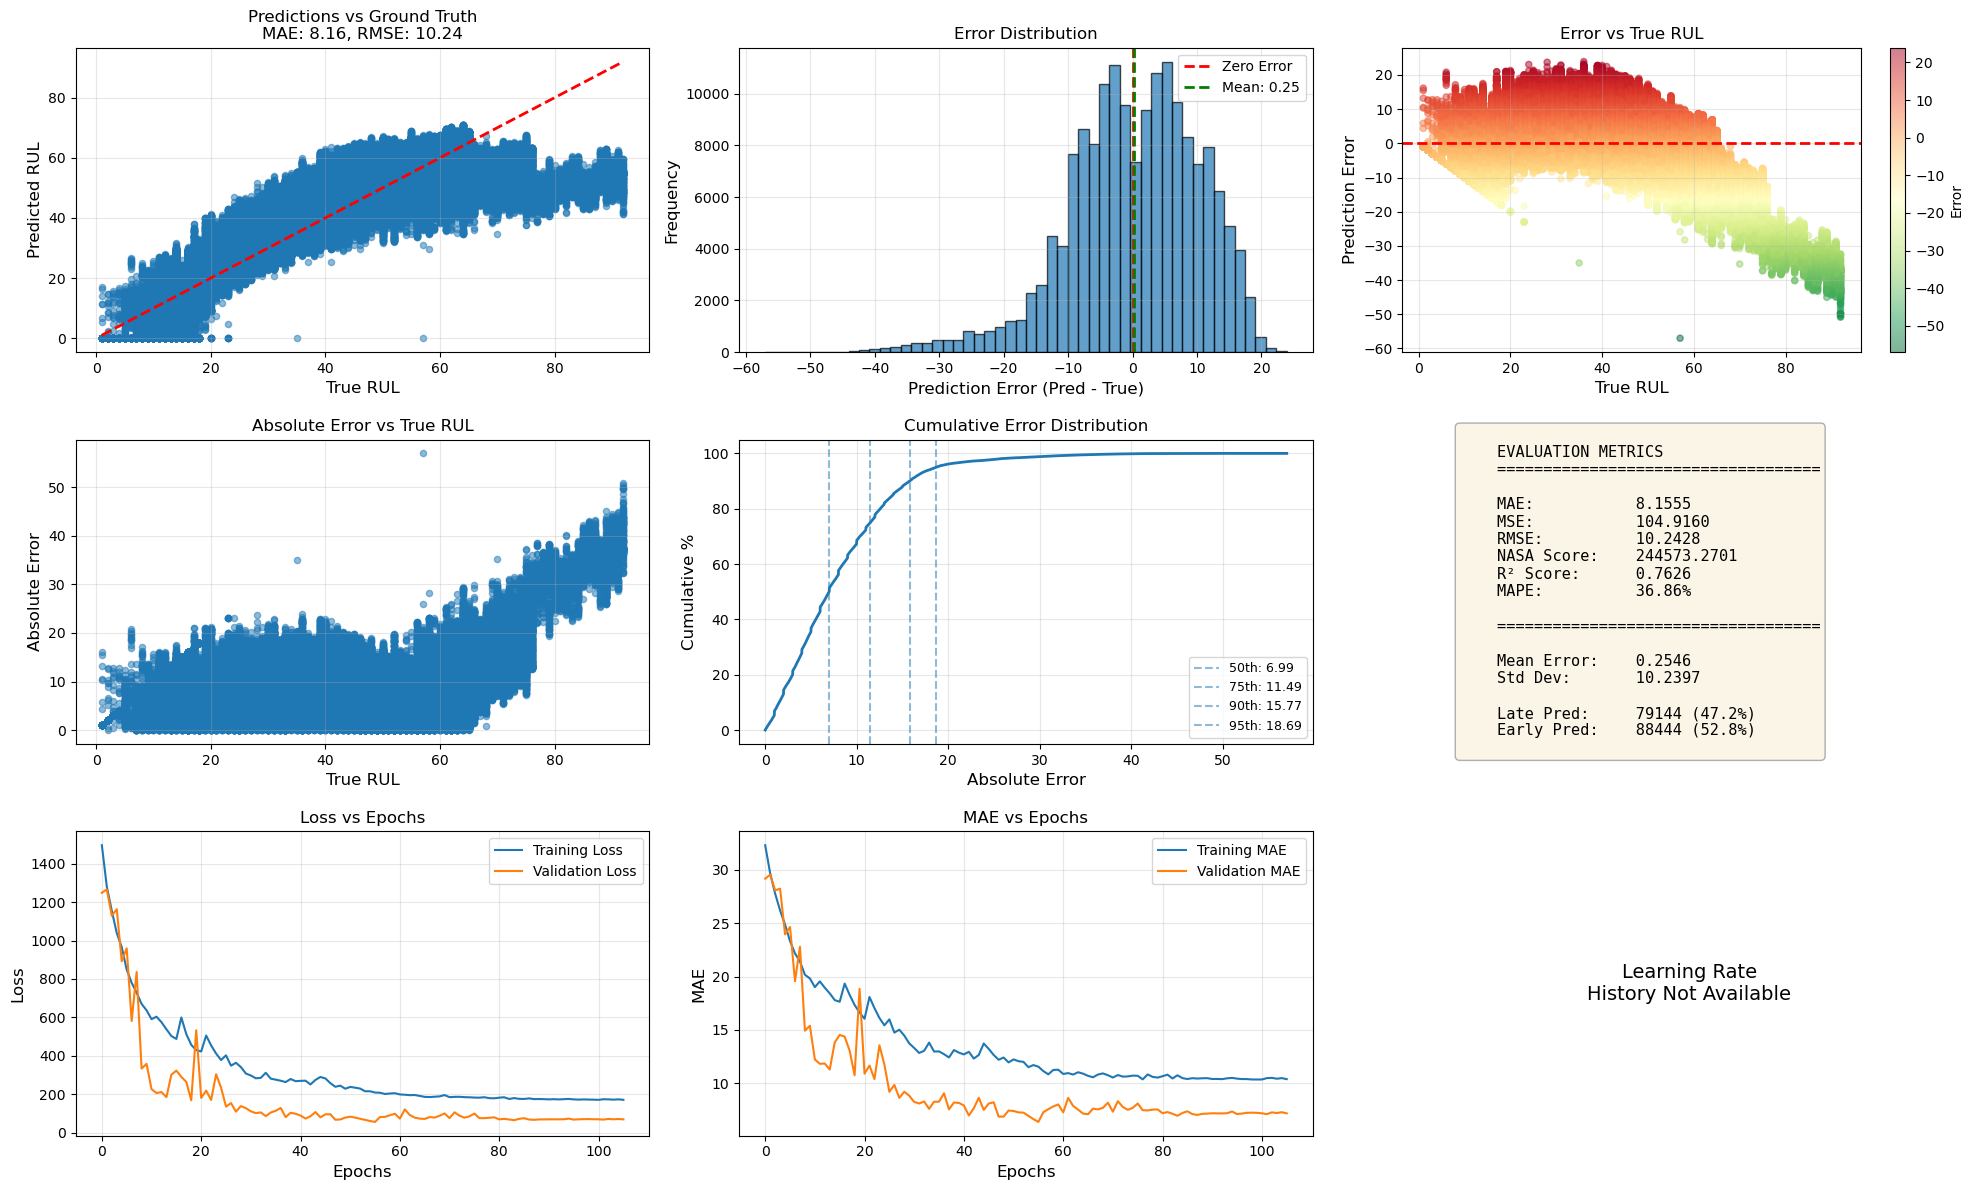

📊 Comprehensive evaluation plot saved as 'comprehensive_evaluation.png'


In [30]:

# %%
# Cell 34: Create Comprehensive Visualization
plot_comprehensive_results(
    test_labels, 
    test_predictions, 
    test_errors, 
    test_metrics,
    history
)

# %%


In [31]:

# Cell 35: Save All Results
# save_results_to_file(comparison_results, 'final_evaluation_results.txt')

# %%
# Cell 36: Prediction Samples Analysis
def show_prediction_samples(y_true, y_pred, n_samples=20):
    """Show sample predictions for inspection"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Random samples
    indices = np.random.choice(len(y_true), min(n_samples, len(y_true)), replace=False)
    
    print("\n" + "="*80)
    print("SAMPLE PREDICTIONS")
    print("="*80)
    print(f"{'Index':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Abs Error':<12} {'Type':<12}")
    print("-"*80)
    
    for idx in sorted(indices):
        true_val = y_true[idx]
        pred_val = y_pred[idx]
        error = pred_val - true_val
        abs_error = abs(error)
        pred_type = "Late (Risk)" if error < 0 else "Early (Safe)"
        
        print(f"{idx:<8} {true_val:<12.2f} {pred_val:<12.2f} {error:<+12.2f} {abs_error:<12.2f} {pred_type:<12}")
    
    print("="*80 + "\n")

show_prediction_samples(test_labels, test_predictions, n_samples=20)

# %%
# Cell 37: Best and Worst Predictions
def show_best_worst_predictions(y_true, y_pred, n=10):
    """Show best and worst predictions"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    errors = y_pred - y_true
    abs_errors = np.abs(errors)
    
    # Best predictions (lowest error)
    best_indices = np.argsort(abs_errors)[:n]
    
    print("\n" + "="*80)
    print(f"TOP {n} BEST PREDICTIONS (Lowest Absolute Error)")
    print("="*80)
    print(f"{'Index':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Abs Error':<12}")
    print("-"*80)
    
    for idx in best_indices:
        print(f"{idx:<8} {y_true[idx]:<12.2f} {y_pred[idx]:<12.2f} {errors[idx]:<+12.2f} {abs_errors[idx]:<12.2f}")
    
    # Worst predictions (highest error)
    worst_indices = np.argsort(abs_errors)[-n:][::-1]
    
    print("\n" + "="*80)
    print(f"TOP {n} WORST PREDICTIONS (Highest Absolute Error)")
    print("="*80)
    print(f"{'Index':<8} {'True RUL':<12} {'Pred RUL':<12} {'Error':<12} {'Abs Error':<12} {'Type':<12}")
    print("-"*80)
    
    for idx in worst_indices:
        pred_type = "Late (Risk)" if errors[idx] < 0 else "Early (Safe)"
        print(f"{idx:<8} {y_true[idx]:<12.2f} {y_pred[idx]:<12.2f} {errors[idx]:<+12.2f} {abs_errors[idx]:<12.2f} {pred_type:<12}")
    
    print("="*80 + "\n")

show_best_worst_predictions(test_labels, test_predictions, n=10)



SAMPLE PREDICTIONS
Index    True RUL     Pred RUL     Error        Abs Error    Type        
--------------------------------------------------------------------------------
12035    45.00        50.69        +5.69        5.69         Early (Safe)
14326    40.00        46.12        +6.12        6.12         Early (Safe)
21196    28.00        42.99        +14.99       14.99        Early (Safe)
26728    19.00        30.55        +11.55       11.55        Early (Safe)
51938    32.00        50.36        +18.36       18.36        Early (Safe)
54877    27.00        42.88        +15.88       15.88        Early (Safe)
83341    16.00        0.00         -16.00       16.00        Late (Risk) 
83835    13.00        0.00         -13.00       13.00        Late (Risk) 
85063    6.00         0.00         -6.00        6.00         Late (Risk) 
90227    69.00        59.57        -9.43        9.43         Late (Risk) 
91761    66.00        56.38        -9.62        9.62         Late (Risk) 
104823   43

In [32]:

# %%
# Cell 38: RUL Range Analysis
def analyze_by_rul_ranges(y_true, y_pred):
    """Analyze performance across different RUL ranges"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Define RUL ranges
    ranges = [
        (0, 25, "Critical (0-25)"),
        (25, 50, "High Risk (25-50)"),
        (50, 75, "Medium Risk (50-75)"),
        (75, 100, "Low Risk (75-100)"),
        (100, 150, "Safe (100+)")
    ]
    
    print("\n" + "="*90)
    print("PERFORMANCE BY RUL RANGE")
    print("="*90)
    print(f"{'Range':<20} {'Count':<10} {'MAE':<10} {'RMSE':<10} {'NASA Score':<15} {'Late%':<10}")
    print("-"*90)
    
    for min_rul, max_rul, label in ranges:
        mask = (y_true >= min_rul) & (y_true < max_rul)
        if np.sum(mask) == 0:
            continue
            
        range_true = y_true[mask]
        range_pred = y_pred[mask]
        
        range_mae = mean_absolute_error(range_true, range_pred)
        range_rmse = np.sqrt(mean_squared_error(range_true, range_pred))
        range_score = score_metric_fn(range_true, range_pred)
        
        range_errors = range_pred - range_true
        late_pct = np.sum(range_errors < 0) / len(range_errors) * 100
        
        print(f"{label:<20} {len(range_true):<10} {range_mae:<10.2f} {range_rmse:<10.2f} {range_score:<15.2f} {late_pct:<10.1f}%")
    
    print("="*90 + "\n")

analyze_by_rul_ranges(test_labels, test_predictions)

# %%



PERFORMANCE BY RUL RANGE
Range                Count      MAE        RMSE       NASA Score      Late%     
------------------------------------------------------------------------------------------
Critical (0-25)      58977      6.61       7.72       54335.40        57.1      %
High Risk (25-50)    59907      8.36       9.89       98041.43        16.6      %
Medium Risk (50-75)  44247      7.92       9.97       50763.88        70.2      %
Low Risk (75-100)    4457       28.22      29.23      41432.55        100.0     %



In [33]:

# Cell 39: Create Summary Report
def create_summary_report():
    """Generate a comprehensive summary report"""
    print("\n" + "="*80)
    print(" "*25 + "FINAL SUMMARY REPORT")
    print("="*80)
    
    print("\n📊 MODEL CONFIGURATION")
    print("-"*80)
    print(f"Window Size:              {WINDOW_SIZE}")
    print(f"Stride:                   {STRIDE}")
    print(f"Batch Size:               {BATCH_SIZE}")
    print(f"Max RUL Clipping:         {MAX_RUL}")
    print(f"Input Features:           {train_data.shape[2]}")
    print(f"Total Parameters:         {best_model.count_params():,}")
    
    print("\n📈 DATASET INFORMATION")
    print("-"*80)
    print(f"Training Samples:         {train_data.shape[0]:,}")
    print(f"Validation Samples:       {val_data.shape[0]:,}")
    print(f"Test Samples:             {test_data.shape[0]:,}")
    print(f"Training Units:           {len(train_units)}")
    print(f"Validation Units:         {len(val_units)}")
    
    print("\n🎯 PERFORMANCE METRICS")
    print("-"*80)
    print("\nValidation Set:")
    for metric, value in val_metrics.items():
        print(f"  {metric.upper():<20s}: {value:.4f}")
    
    print("\nTest Set:")
    for metric, value in test_metrics.items():
        print(f"  {metric.upper():<20s}: {value:.4f}")
    
    print("\n⚠️  RISK ANALYSIS")
    print("-"*80)
    test_errors = test_predictions.flatten() - test_labels.flatten()
    late_count = np.sum(test_errors < 0)
    early_count = np.sum(test_errors > 0)
    
    print(f"Late Predictions (Under-prediction):   {late_count:>6} ({late_count/len(test_errors)*100:>5.1f}%)")
    print(f"Early Predictions (Over-prediction):   {early_count:>6} ({early_count/len(test_errors)*100:>5.1f}%)")
    print(f"\nMean Bias:                             {np.mean(test_errors):>+7.2f}")
    
    if np.mean(test_errors) < -2:
        print("⚠️  Model tends to under-predict (late predictions) - Higher risk!")
    elif np.mean(test_errors) > 2:
        print(" Model tends to over-predict (early predictions) - More conservative")
    else:
        print(" Model is well-balanced")
    
    print("\n" + "="*80)
    print(" "*20 + "END OF SUMMARY REPORT")
    print("="*80 + "\n")

create_summary_report()



                         FINAL SUMMARY REPORT

📊 MODEL CONFIGURATION
--------------------------------------------------------------------------------
Window Size:              50
Stride:                   25
Batch Size:               2048
Max RUL Clipping:         125
Input Features:           90
Total Parameters:         398,133

📈 DATASET INFORMATION
--------------------------------------------------------------------------------
Training Samples:         151,566
Validation Samples:       67,877
Test Samples:             167,588
Training Units:           7
Validation Units:         2

🎯 PERFORMANCE METRICS
--------------------------------------------------------------------------------

Validation Set:
  MAE                 : 6.3674
  MSE                 : 56.7745
  RMSE                : 7.5349
  NASA_SCORE          : 61027.3290
  MAPE                : 32.9229
  R2                  : 0.8685

Test Set:
  MAE                 : 8.1555
  MSE                 : 104.9160
  RMSE            

In [34]:

# %%
# Cell 40: Export Predictions to CSV
def export_predictions(y_true, y_pred, filename='predictions.csv'):
    """Export predictions to CSV file"""
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    errors = y_pred - y_true
    
    df_pred = pd.DataFrame({
        'True_RUL': y_true,
        'Predicted_RUL': y_pred,
        'Error': errors,
        'Absolute_Error': np.abs(errors),
        'Prediction_Type': ['Late' if e < 0 else 'Early' for e in errors]
    })
    
    # df_pred.to_csv(filename, index=False)
    print(f" Predictions exported to '{filename}'")
    print(f"   Total records: {len(df_pred)}")
    
    return df_pred

predictions_df = export_predictions(test_labels, test_predictions, 'test_predictions.csv')
predictions_df.head(10)


 Predictions exported to 'test_predictions.csv'
   Total records: 167588


,True_RUL,Predicted_RUL,Error,Absolute_Error,Prediction_Type
0,65.0,57.283138,-7.716862,7.716862,Late
1,65.0,56.793179,-8.206821,8.206821,Late
2,65.0,56.751949,-8.248051,8.248051,Late
3,65.0,56.729542,-8.270458,8.270458,Late
4,65.0,56.661999,-8.338001,8.338001,Late
5,65.0,56.710331,-8.289669,8.289669,Late
6,65.0,56.768856,-8.231144,8.231144,Late
7,65.0,57.083984,-7.916016,7.916016,Late
8,65.0,57.366516,-7.633484,7.633484,Late
9,65.0,57.665028,-7.334972,7.334972,Late
